In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import numpy as np
import os.path as osp
import matplotlib.pylab as plt
from sklearn.manifold import TSNE

from general_tools.in_out.basics import unpickle_data
from general_tools.in_out import create_dir
from general_tools.notebook.tf import reset_tf_graph

from general_tools.plotting import stack_images_horizontally, stack_images_in_square_grid
from general_tools.clustering.plt import plot_2d_embedding_in_grid_greedy_way, plot_2d_embedding_in_grid_forceful

from geo_tool import Point_Cloud

import tf_lab.point_clouds.in_out as pio

from tf_lab.data_sets.shape_net import  pc_loader as sn_pc_loader

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import PointCloudDataSet

from tf_lab.in_out.basics import read_saved_epochs
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import pairwise_distances

from general_tools.clustering.dist import incremental_farthest_sampling, evaluate_solution
from general_tools.in_out.basics import files_in_subdirs

from harnessing_geometric_triplets import make_triplets, save_triplets, plot_triplets
from general_tools.clustering.convenience import find_nearest_neighbors
from collections import Counter

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [167]:
def detect_outliers(features, outlier_fraction, random_seed):
    clf = IsolationForest(max_samples=100, max_features=64, random_state=random_seed, contamination=outlier_fraction)
    clf.fit(features)
    y_pred = clf.predict(features)
    outliers = np.where(y_pred == -1)[0]
    print 'Outliers detected = ', len(outliers)
    return outliers

def pick_exemplars(all_pdists, n_exmplars, method='random', exclude=[], random_seed=None, latent_codes=None):
    n = all_pdists.shape[0]
    
    if random_seed is not None:
        np.random.seed(random_seed)
        
    available_pop = np.setdiff1d(np.arange(n), exclude)
    
    if method == 'random':
        exemplars = np.random.choice(available_pop, n_exmplars, replace=False)
    
    elif method == 'max_deg':            
        index, _ = find_nearest_neighbors(latent_codes[available_pop], k=2)
        index = available_pop[index]
        count = Counter(index.flatten())
        exemplars = [i[0] for i in count.most_common(n_exmplars)]
        
    elif method == 'fps':                    
        exemplars = incremental_farthest_sampling(all_pdists, n_exemplars, exclude, random_seed)
        print 'Average Min Distance of FPS exemplars:', evaluate_solution(latent_codes[exemplars])
    else:
        assert(False)
    assert(len(np.unique(exemplars)) == n_exmplars)
    return exemplars

def tsne_exemplars(exemplars, latent_codes, save_file, random_seed=None):    
    # Plot TSNE of examplars.
    model = TSNE(n_components=2, random_state=random_seed, init='pca')
    tsne_coords = model.fit_transform(latent_codes[exemplars])

    # Make a list with the file-names of all to be used images.
    image_files = []
    for i in exemplars:
        image_files.append(osp.join(top_image_dir, model_ids[i], image_view_tag))
        
    small_dim = 400
    big_dim = int(np.ceil(np.sqrt(len(exemplars)))) * small_dim
    plot_2d_embedding_in_grid_forceful(tsne_coords, image_files, big_dim, small_dim, save_file);
    
def visualize_shapes_generator(data_to_vis, model_ids, top_image_dir, image_view_tag):
    for i in data_to_vis:
        image_files = []
        try:
            for j in i:
                image_files.append(osp.join(top_image_dir, model_ids[j], image_view_tag))
        except:
            image_files.append(osp.join(top_image_dir, model_ids[i], image_view_tag))
            
        yield stack_images_horizontally(image_files)

        
def close_triplets_gen(all_pdists, exclude_list, min_dist=0, vis=False):
    exclude_list = np.unique(exclude_list)
    n = all_pdists.shape[0]    
    targets = np.setdiff1d(np.arange(n), exclude_list)
    for i in targets:            
        candidates = np.arange(n)
        candidates = np.setdiff1d(candidates, exclude_list, assume_unique=True)
        candidates = np.setdiff1d(candidates, i, assume_unique=True)
        relevant_dists = all_pdists[i, candidates]
        big_enough = relevant_dists > min_dist
        relevant_dists = relevant_dists[big_enough]
        candidates = candidates[big_enough]        
        aso = np.argsort(relevant_dists)
        aso = candidates[aso]
        triplet = [i, aso[0], aso[1]]        
        if vis:            
            image_files = []
            image_files.append(osp.join(top_image_dir, model_ids[triplet[0]], image_view_tag))
            image_files.append(osp.join(top_image_dir, model_ids[triplet[1]], image_view_tag))
            image_files.append(osp.join(top_image_dir, model_ids[triplet[2]], image_view_tag))
            yield triplet, stack_images_horizontally(image_files)
        else:
            yield triplet

            
def far_triplets_gen(all_pdists, exclude_list, max_dist=np.inf):
    exclude_list = np.unique(exclude_list)
    n = all_pdists.shape[0]
    for i in range(n):
        candidates = np.arange(n)
        candidates = np.setdiff1d(candidates, exclude_list, assume_unique=True)
        candidates = np.setdiff1d(candidates, i, assume_unique=True)
        relevant_dists = all_pdists[i, candidates]
        small_enough = relevant_dists < max_dist
        relevant_dists = relevant_dists[small_enough]
        candidates = candidates[small_enough]
        aso = np.argsort(relevant_dists)
        aso = candidates[aso]
        image_files = []
        image_files.append(osp.join(top_image_dir, model_ids[i], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[aso[-2]], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[aso[-1]], image_view_tag))
        yield stack_images_horizontally(image_files)
        
def proximity_bounds(all_pdists, exemplars, lb=0.01, rb=50):
    pdists_ = all_pdists[exemplars]
    pdists_ = np.triu(pdists_, 0) 
    pdists_ = pdists_[pdists_ > 0]
    too_close_threr = np.percentile(pdists_, lb)
    too_far_thres = np.percentile(pdists_, rb)
    return too_close_threr, too_far_thres


def find_duplicates(all_pdists, exemplars, thres):
    res = dict()
    exemplars = np.array(exemplars)
    for ex in exemplars:
        collisions = np.where(all_pdists[ex, exemplars] < thres)[0]
        if len(collisions) > 1:
            collisions = exemplars[collisions]
            collisions = np.setdiff1d(collisions, ex) 
            if len(collisions) > 0:
                res[ex] = collisions            
    return res

def keep_one_from_duplicates(duplicate_dict):
    excluded = set()
    res = set()
    for key in duplicate_dict.keys():
        if key not in excluded:
            res.add(key)
        excluded.update(duplicate_dict[key])        
        
    excluded.difference_update(res)
    return list(res), list(excluded)

In [191]:
random_seed = 42
outlier_fraction = 0.01  # Percent of data instances that will be automatically disreguarded.
n_exemplars = 1000      # Shapes that will be used to create contrasting triplets.
top_data_dir = top_data_dir = '/orions4-zfs/projects/optas/DATA/'

In [6]:
# load AE model
class_name = 'chair'
syn_id = snc_category_to_synth_id()[class_name]
ae_loss = 'emd'
ae_id = '12' # 128 bottleneck

ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))

if ae_conf.train_dir != ae_net_dir:
    ae_conf.train_dir = ae_net_dir
    ae_conf.save(osp.join(ae_conf.train_dir, 'configuration'))
    
reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)

saved_epochs = read_saved_epochs(ae_conf.train_dir)
load_epoch = saved_epochs[-1]
ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

Model restored in epoch 1000.


In [7]:
# Load Raw Point-Clouds of class
n_pc_samples = 2048
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))

pclouds_path = osp.join(pclouds_path, syn_id)
file_names = [f for f in files_in_subdirs(pclouds_path, '.ply')]
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [8]:
pcloud_data = PointCloudDataSet(pclouds, labels=model_ids, init_shuffle=False)
_, latent_codes, temp_names = ae.embedding_at_tensor(pcloud_data, ae_conf, tensor_name='bottleneck')
assert(np.alltrue(temp_names==model_ids))

In [9]:
top_image_dir = '/orions4-zfs/projects/optas/DATA/Meshes/Shape_Net_Core/2015_Summer_OUT/Images/'
top_image_dir = osp.join(top_image_dir, syn_id)
image_view_tag = 'image_p020_t337_r005.png'

top_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/3d_neighbs_as_context/pilot_triplets_3/'
top_out_dir = osp.join(top_out_dir, 'outlier_frac_' + str(int(outlier_fraction * 100)))
create_dir(top_out_dir)

'/orions4-zfs/projects/optas/DATA/OUT/3d_neighbs_as_context/pilot_triplets_3/outlier_frac_20'

In [192]:
all_pdists = pairwise_distances(latent_codes)
outliers = detect_outliers(latent_codes, outlier_fraction, random_seed)

Outliers detected =  68


In [193]:
# vg = visualize_shapes_generator(outliers, model_ids, top_image_dir, image_view_tag)

In [263]:
# vg.next()

StopIteration: 

In [73]:
n_chairs = len(latent_codes)
entire_pop = np.arange(n_chairs)
min_bound, max_bound = proximity_bounds(all_pdists, entire_pop, lb=0.005, rb=50)

In [74]:
dups = find_duplicates(all_pdists, entire_pop, min_bound)

In [75]:
data_to_vis = []
for k, v in dups.iteritems():
    temp = v.tolist()
    temp.append(k)
    data_to_vis.append(temp)
    
vg = visualize_shapes_generator(data_to_vis, model_ids, top_image_dir, image_view_tag)

In [76]:
kept, duplicates = keep_one_from_duplicates(dups)
print len(kept)
print len(duplicates)

356
576


In [278]:
gen_method = 'max_deg'
gen_method_tag = gen_method + '_sampling'
rule = 'closest_nn'
inlier_sampling = False
sampling_tag = 'inlier_' if inlier_sampling else 'entire_collection_'

In [279]:
exemplars = pick_exemplars(all_pdists, n_exemplars, method=gen_method, exclude=duplicates, \
                           random_seed=random_seed, latent_codes=latent_codes)

# tsne_exemplars(exemplars, latent_codes, 'max_deg_exlude_dups.png', random_seed)

if inlier_sampling:
    exclude_list = np.setdiff1d(entire_pop, exemplars)
    close_gen = close_triplets_gen(all_pdists, exclude_list)
    triplets = [t for t in close_gen]
else:
    triplets = make_triplets(exemplars, all_pdists, duplicates, rule)

print 'Unique chairs: ', len(np.unique(np.array(triplets).flatten()))

Unique chairs:  1736


In [280]:
# triplet_out_dir = create_dir(osp.join(top_out_dir, rule, sampling_tag + gen_method_tag, 'data'))
# save_triplets(triplets, top_image_dir, triplet_out_dir, model_ids)

triplet_out_dir = create_dir(osp.join(top_out_dir, rule, sampling_tag + gen_method_tag, 'images'))
plot_triplets(triplets, top_image_dir, triplet_out_dir, model_ids)

In [ ]:
A = inlier_random
B = inlier_max_deg
C = entire_collection_random
D = entire_collection_max_deg

In [395]:
v_kept = visualize_shapes_generator(kept, model_ids, top_image_dir, image_view_tag)

In [427]:
tsne_exemplars(list(kept), latent_codes, 'test.png', random_seed)


In [866]:
rule = 'closest_nn'
triplets = make_triplets(exemplars, all_pdists, thrown, rule, far_threshold=0.5)

In [864]:
len(np.unique(triplets))

1735

In [867]:
vis = visualize_shapes_generator(triplets, model_ids, top_image_dir, image_view_tag)

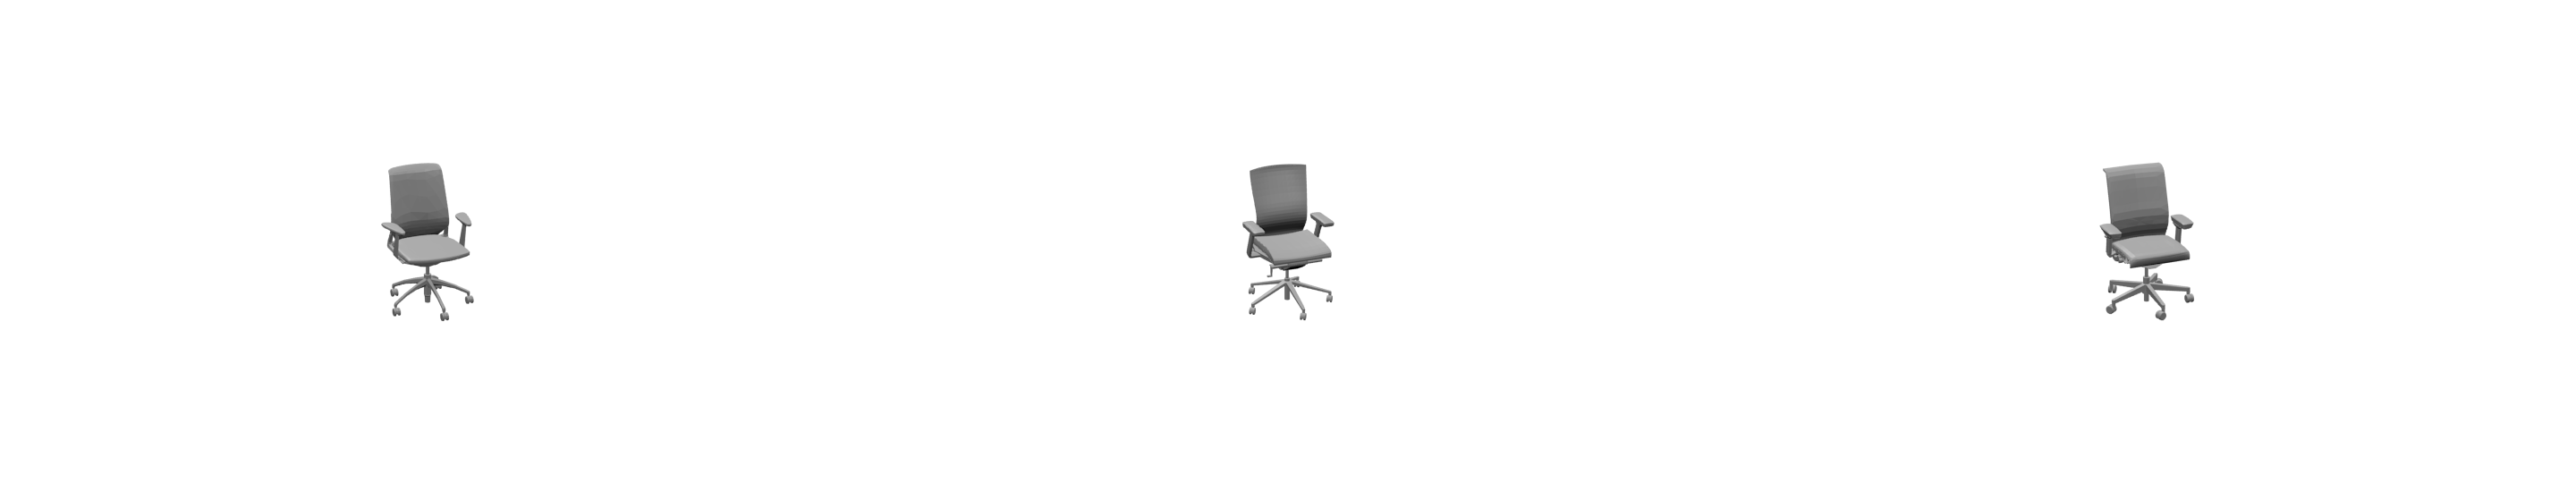

In [872]:
vis.next()

In [28]:
triplet_out_dir = create_dir(osp.join(top_out_dir, rule))
triplets = []
for rule in ['closest_nn', 'one_far', 'both_far']:
    triplets.append(make_triplets(fps_sol, all_pdists, outliers, rule))

triplet_out_dir = create_dir(osp.join(top_out_dir, 'all_rules', 'images'))
plot_triplets_in_multiple_contexts(triplets, top_image_dir, triplet_out_dir, model_ids)